In [1]:
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import cv2
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,GlobalAveragePooling2D, Input

from keras.layers import Input, BatchNormalization, Activation
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.optimizers import Adam
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from mlxtend.plotting import plot_confusion_matrix
import random
from imblearn.over_sampling import RandomOverSampler

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tf.config.experimental.list_physical_devices('GPU'))
print(tf.__version__)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13782572375493888976
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13169830356443116855
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 388164196880457959
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3641047262562587165
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:2"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 9483211696747274304
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:3"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16280074232159391781
physical_device_desc: "device: XLA_GPU device"
]
[]
2.3.1


## Reading Data 

In [3]:
labelsdf= pd.read_csv("worDwiseLabels/gt.csv")

In [4]:
labelsdf.head()

,File_name,Script,translation,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,word_1.png,Arabic,فروجنا,NaN,NaN,NaN,NaN
1,word_2.png,Arabic,المشوى,NaN,NaN,NaN,NaN
2,word_3.png,Arabic,حلال,NaN,NaN,NaN,NaN
3,word_4.png,Arabic,و,NaN,NaN,NaN,NaN
4,word_5.png,Arabic,طازج,NaN,NaN,NaN,NaN


In [5]:
(labelsdf['Script']).value_counts()

Latin       42629
Korean       4476
Japanese     4108
Arabic       3505
Bangla       3214
Chinese      2702
Symbols      1133
3               1
Name: Script, dtype: int64

In [6]:
labelsdf = labelsdf.dropna(axis=0, subset=['Script'])
labelsdf = labelsdf.dropna(axis=0, subset=['File_name'])
labelsdf=labelsdf[(labelsdf['Script'] !='Symbols')]
labelsdf=labelsdf[(labelsdf['Script'] !='3')]

Text(0.5, 1.0, 'number of images of each script')

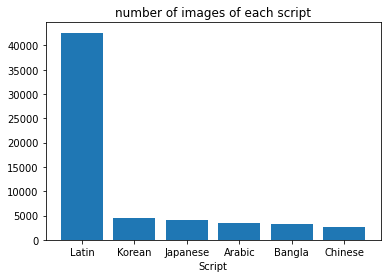

In [7]:
ab=labelsdf['Script'].value_counts()
plt.bar(ab.index,ab)
plt.xlabel('Script')
plt.title('number of images of each script')

### Balancing the imbalanced data by assigning weights to classes

##### We did weights optimization of classes using inverse frequencies of classes. We will then pass these weights to cost function of the model

In [8]:
class_index={0:'Arabic',1:'Bangla', 2:'Chinese', 3:'Japanese', 4:'Korean',5:'Latin'}
total=labelsdf['Script'].value_counts().sum()
vc=labelsdf['Script'].value_counts()
class_weights={val:total/vc[class_index[val]]for val in class_index}
class_weights

{0: 17.29928673323823,
 1: 18.865588052271313,
 2: 22.440414507772022,
 3: 14.75998052580331,
 4: 13.546470062555853,
 5: 1.4223650566515753}

### Splitting data into Train, Test and Validation

In [9]:
labelsdf_train = labelsdf.sample(frac = 0.85) 
labelsdf_test = labelsdf.drop(labelsdf_train.index)
labelsdf_train = labelsdf_train.reset_index()

***

## Classification Report Plot function

In [10]:
def plot_classification_report(cr, title='Classification report ', with_avg_total=False, cmap=plt.cm.summer):
    title = title or 'Classification report'
    lines = cr.split('\n')
    classes = []
    matrix = []

    for line in lines[2:(len(lines)-4)]:
        s = line.split()
        classes.append(s[0])
        value = [float(x) for x in s[1: len(s) - 1]]
        matrix.append(value)

    fig, ax = plt.subplots(1)

    for column in range(len(matrix)+1):
        for row in range(len(classes)):
            if row < len(classes) and column < len(matrix[0]):
                txt = matrix[row][column]
                ax.text(column,row,matrix[row][column],va='center',ha='center')

    
    fig = plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.ylabel('Classes')
    plt.xlabel('Measures')
    plt.show()

## Generating Train, Test and Validation Iterator using Keras ImageDataGenerator

In [11]:
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.15)
train_it=datagen.flow_from_dataframe(
dataframe=labelsdf_train,
directory="wordWise_Padded/",
x_col="File_name",
y_col="Script",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(128,128))

/home/prastogi/anaconda3/envs/my_env_py/lib/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 300 invalid image filename(s) in x_col="File_name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 43554 validated image filenames belonging to 6 classes.


In [12]:
val_it=datagen.flow_from_dataframe(
dataframe=labelsdf_train,
directory="wordWise_Padded/",
x_col="File_name",
y_col="Script",
subset="validation",
batch_size=32,
seed=42,
shuffle=False,
class_mode="categorical",
target_size=(128,128))

/home/prastogi/anaconda3/envs/my_env_py/lib/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 300 invalid image filename(s) in x_col="File_name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 7685 validated image filenames belonging to 6 classes.


In [10]:
testgen=ImageDataGenerator(rescale=1./255.)
test_it=testgen.flow_from_dataframe(
dataframe=labelsdf_test,
directory="wordWise_Padded/",
x_col="File_name",
y_col="Script",
batch_size=32,
seed=42,
shuffle=False,
class_mode="categorical",
target_size=(128,128))

Found 9046 validated image filenames belonging to 6 classes.


/home/prastogi/anaconda3/envs/my_env_py/lib/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 49 invalid image filename(s) in x_col="File_name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [14]:
freqClasses = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0}

for x in test_it.classes:
    freqClasses[x] = freqClasses[x]+1
    
freqClasses

{0: 507, 1: 455, 2: 420, 3: 598, 4: 694, 5: 6354}

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

def samplesMetrics(classes, y_pred, nSamples=30):
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    allPredictions = pd.DataFrame(list(zip(classes, y_pred)), columns=['Classes', 'yPredicted'])

    for i in range(nSamples):

        labelsdf_Samples= allPredictions.sample(n=500)

        accuracy = accuracy_score(labelsdf_Samples['Classes'],labelsdf_Samples['yPredicted'])
        accuracies.append(accuracy)

        metrics = precision_recall_fscore_support(labelsdf_Samples['Classes'],labelsdf_Samples['yPredicted'],average='weighted')
        precisions.append(metrics[0])
        recalls.append(metrics[1])
        f1_scores.append(metrics[2])

    metricsEvaluated = {'Accuracy': accuracies,'Precision': precisions,'Recall': recalls, 'F1-Score': f1_scores}
    metricsDf = pd.DataFrame(metricsEvaluated)
    return metricsDf


def samplesMetricsFromModel(model,test_it):
    Y_pred = model.predict_generator(test_it) 
    y_pred = np.argmax(Y_pred, axis=1)
    metricsDf= samplesMetrics(test_it.classes, y_pred, nSamples=30)
    return  metricsDf

In [15]:
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1


***

## ResNet Model with imagenet pretrained weights

In [25]:
with strategy.scope():    
    Resnet_model = keras.applications.resnet50.ResNet50(weights="imagenet", include_top=False, input_shape= (128,128,3))
    x = Resnet_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    predictions = Dense(6, activation= 'softmax')(x)
    Resnetmodel = Model(inputs = Resnet_model.input, outputs =predictions )
    Resnetmodel.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

__________________________________________________________________________________________________
conv4_block5_1_bn (BatchNormali (None, 8, 8, 256)    1024        conv4_block5_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block5_1_relu (Activation (None, 8, 8, 256)    0           conv4_block5_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block5_2_conv (Conv2D)    (None, 8, 8, 256)    590080      conv4_block5_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block5_2_bn (BatchNormali (None, 8, 8, 256)    1024        conv4_block5_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block5_2_relu (Activation (None, 8, 8, 256)    0           conv4_block5_2_bn[0][0]          
__________

In [26]:
from keras.optimizers import SGD, Adam
adam = Adam(lr=0.001)
Resnetmodel.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['Recall','Precision','Accuracy'])

In [27]:
es = EarlyStopping(monitor='val_recall', mode='min', verbose=1,patience=25)
checkpoint = ModelCheckpoint('modelsPadded/modelinResnet_padded.h5',save_best_only=True,monitor='val_loss')
historyRes=Resnetmodel.fit(train_it,validation_data=val_it,epochs=120,steps_per_epoch=32,callbacks=[es,checkpoint])

Epoch 1/120
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
32/32 [==============================] - 1282s 40s/step - loss: 1.3626 - precision: 0.7306 - accuracy: 0.0109 - recall: 0.5137 - val_precision: 0.0683 - val_accuracy: 0.3741 - val_loss: 98.2484 - val_recall: 0.0683
Epoch 2/120
32/32 [==============================] - 1243s 39s/step - loss: 1.3849 - precision: 0.7462 - accuracy: 0.0145 - recall: 0.5771 - val_precision: 0.7050 - val_accuracy: 0.9017 - val_loss: 21957.0762 - val_recall: 0.7050
Epoch 3/120
32/32 [==============================] - 1258s 39s/step - loss: 1.6170 - precision: 0.6939 - accuracy: 0.0055 - recall: 0.5801 - val_precision: 0.7050 - val_accuracy: 0.9017 - val_loss: 101490.6484 - val_recall: 0.7050
Epoch 4/120
32/32 [==============================] - 1242s 39s/step - loss: 1.2527 - precision: 0.7262 - accuracy: 0.0011 - recall: 0.6035 - val_precision: 0.7050 - val_accuracy: 0.9017 - val_loss: 1331.8605 - val_recall: 0.7050
E

In [16]:
Resnetmodel = keras.models.load_model("modelsPadded/modelinResnet_padded.h5")

In [17]:
score = Resnetmodel.evaluate_generator(test_it)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:
Please use Model.evaluate, which supports generators.
Test loss: 0.5104545950889587
Test accuracy: 0.7824546098709106


In [18]:
Y_pred = Resnetmodel.predict_generator(test_it) 
y_predRes = np.argmax(Y_pred, axis=1)

Instructions for updating:
Please use Model.predict, which supports generators.


### Confusion Matrix and Classification Report


In [19]:
resnet_cm=confusion_matrix(test_it.classes, y_predRes)
resnet_cm

array([[ 354,    0,    0,    1,    6,  146],
       [   1,  296,    0,    1,    9,  148],
       [   4,    0,   29,  130,   27,  230],
       [   4,    0,    8,  137,   45,  404],
       [  12,    2,    2,   14,  430,  234],
       [  40,    7,    3,   20,   62, 6222]])

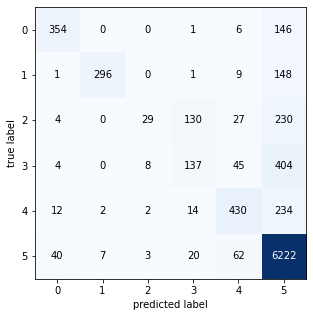

In [22]:
plot_confusion_matrix(resnet_cm,figsize=(5,5))
plt.show()

In [23]:
resnet_cr = classification_report(test_it.classes, y_predRes)
print(resnet_cr)

              precision    recall  f1-score   support

           0       0.85      0.70      0.77       507
           1       0.97      0.65      0.78       455
           2       0.69      0.07      0.13       420
           3       0.45      0.23      0.30       598
           4       0.74      0.62      0.68       694
           5       0.84      0.98      0.91      6354

    accuracy                           0.83      9028
   macro avg       0.76      0.54      0.59      9028
weighted avg       0.81      0.83      0.80      9028



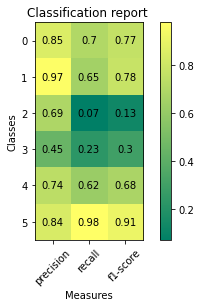

In [24]:
resnet_cr = """    precision    recall  f1-score   support

           0       0.85      0.70      0.77       507
           1       0.97      0.65      0.78       455
           2       0.69      0.07      0.13       420
           3       0.45      0.23      0.30       598
           4       0.74      0.62      0.68       694
           5       0.84      0.98      0.91      6354

    accuracy                           0.83      9028
   macro avg       0.76      0.54      0.59      9028
weighted avg       0.81      0.83      0.80      9028"""

plot_classification_report(resnet_cr)


In [12]:
model = keras.models.load_model("modelsPadded/modelinResnet_padded.h5")   
metricsDf = samplesMetricsFromModel(model,test_it)
metricsDf.to_csv("ResNetWeights_Padded.csv")
metricsDf

Instructions for updating:
Please use Model.predict, which supports generators.


/home/prastogi/anaconda3/envs/my_env_py/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Accuracy,Precision,Recall,F1-Score
0,0.840,0.798427,0.840,0.809665
1,0.838,0.818126,0.838,0.809112
2,0.834,0.825035,0.834,0.804192
3,0.814,0.809837,0.814,0.776897
4,0.826,0.830387,0.826,0.794648
5,0.826,0.799233,0.826,0.789880
6,0.844,0.845054,0.844,0.815444
7,0.848,0.844214,0.848,0.821126
8,0.824,0.777037,0.824,0.782027
9,0.832,0.815615,0.832,0.800461


In [14]:
def getAvgStd(csvFile,column='F1-Score'):
    df= pd.read_csv(csvFile)
    avg=np.mean(df[column])
    std=np.std(df[column])
    return avg,std
    
avg, std = getAvgStd("ResNetWeights_Padded.csv")
print("Mean = ", avg)
print("Standard Deviation = ", std)

Mean =  0.8046181333012085
Standard Deviation =  0.016017155931433047


## ResNet without pretrained weights

In [33]:
with strategy.scope():    
    Resnet_model = keras.applications.resnet50.ResNet50( include_top=False, input_shape= (128,128,3))
    x = Resnet_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    predictions = Dense(6, activation= 'softmax')(x)
    Resnetmodel = Model(inputs = Resnet_model.input, outputs =predictions )
    Resnetmodel.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

conv4_block2_3_conv (Conv2D)    (None, 8, 8, 1024)   263168      conv4_block2_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block2_3_bn (BatchNormali (None, 8, 8, 1024)   4096        conv4_block2_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_block2_add (Add)          (None, 8, 8, 1024)   0           conv4_block1_out[0][0]           
                                                                 conv4_block2_3_bn[0][0]          
__________________________________________________________________________________________________
conv4_block2_out (Activation)   (None, 8, 8, 1024)   0           conv4_block2_add[0][0]           
__________________________________________________________________________________________________
conv4_block3_1_conv (Conv2D)    (None, 8, 8, 256)    262400      conv4_block2_out[0][0]           
__________

In [34]:
from keras.optimizers import SGD, Adam
adam = Adam(lr=0.001)
Resnetmodel.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['Recall','Precision','Accuracy'])

In [35]:
es = EarlyStopping(monitor='val_recall', mode='min', verbose=1,patience=25)
checkpoint = ModelCheckpoint('modelsPadded/modelinResnet_padded_no_weights.h5',save_best_only=True,monitor='val_loss')
historyRes=Resnetmodel.fit(train_it,validation_data=val_it,epochs=120,steps_per_epoch=32,callbacks=[es,checkpoint])

Epoch 1/120
32/32 [==============================] - 1480s 46s/step - loss: 1.4895 - precision: 0.7175 - accuracy: 0.0076 - recall: 0.5283 - val_precision: 0.0740 - val_accuracy: 0.5407 - val_loss: 329.4026 - val_recall: 0.0740
Epoch 2/120
32/32 [==============================] - 1475s 46s/step - loss: 1.0933 - precision: 0.8110 - accuracy: 0.0037 - recall: 0.5488 - val_precision: 0.7050 - val_accuracy: 0.9017 - val_loss: 153.0932 - val_recall: 0.7050
Epoch 3/120
32/32 [==============================] - 1523s 48s/step - loss: 1.1844 - precision: 0.7427 - accuracy: 0.0037 - recall: 0.5752 - val_precision: 0.7050 - val_accuracy: 0.1385 - val_loss: 14.9013 - val_recall: 0.7050
Epoch 4/120
32/32 [==============================] - 1492s 47s/step - loss: 1.0934 - precision: 0.7833 - accuracy: 0.0031 - recall: 0.6211 - val_precision: 0.7050 - val_accuracy: 0.0000e+00 - val_loss: 1.7120 - val_recall: 0.7050
Epoch 5/120
32/32 [==============================] - 1416s 44s/step - loss: 1.0009 - pr

In [25]:
Resnetmodel = keras.models.load_model("modelsPadded/modelinResnet_padded_no_weights.h5")

In [26]:
score = Resnetmodel.evaluate_generator(test_it)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6909838318824768
Test accuracy: 0.7600797414779663


In [27]:
Y_predP = Resnetmodel.predict_generator(test_it) 
y_predResP = np.argmax(Y_pred, axis=1)

### Confusion Matrix and Classification Report

In [28]:
resnetP_cm=confusion_matrix(test_it.classes, y_predResP)
resnetP_cm

array([[ 354,    0,    0,    1,    6,  146],
       [   1,  296,    0,    1,    9,  148],
       [   4,    0,   29,  130,   27,  230],
       [   4,    0,    8,  137,   45,  404],
       [  12,    2,    2,   14,  430,  234],
       [  40,    7,    3,   20,   62, 6222]])

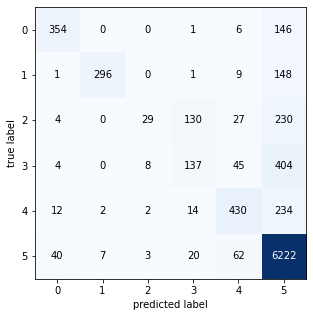

In [29]:
plot_confusion_matrix(resnetP_cm,figsize=(5,5))
plt.show()

In [30]:
resnetP_cr = classification_report(test_it.classes, y_predResP)
print(resnetP_cr)

              precision    recall  f1-score   support

           0       0.85      0.70      0.77       507
           1       0.97      0.65      0.78       455
           2       0.69      0.07      0.13       420
           3       0.45      0.23      0.30       598
           4       0.74      0.62      0.68       694
           5       0.84      0.98      0.91      6354

    accuracy                           0.83      9028
   macro avg       0.76      0.54      0.59      9028
weighted avg       0.81      0.83      0.80      9028



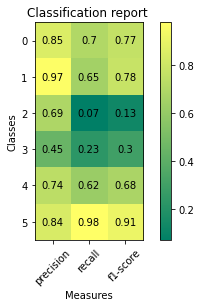

In [31]:
resnetP_cr_ = """    precision    recall  f1-score   support

           0       0.85      0.70      0.77       507
           1       0.97      0.65      0.78       455
           2       0.69      0.07      0.13       420
           3       0.45      0.23      0.30       598
           4       0.74      0.62      0.68       694
           5       0.84      0.98      0.91      6354

    accuracy                           0.83      9028
   macro avg       0.76      0.54      0.59      9028
weighted avg       0.81      0.83      0.80      9028"""

plot_classification_report(resnetP_cr_)


In [16]:
model = keras.models.load_model("modelsPadded/modelinResnet_padded_no_weights.h5")   
metricsDf = samplesMetricsFromModel(model,test_it)
metricsDf.to_csv("ResNetNoWeights_Padded.csv")
metricsDf

/home/prastogi/anaconda3/envs/my_env_py/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Accuracy,Precision,Recall,F1-Score
0,0.786,0.739583,0.786,0.732494
1,0.784,0.817359,0.784,0.733347
2,0.788,0.756684,0.788,0.733563
3,0.812,0.837378,0.812,0.769898
4,0.750,0.784095,0.750,0.683535
5,0.762,0.751846,0.762,0.704109
6,0.796,0.763118,0.796,0.745490
7,0.792,0.745052,0.792,0.740728
8,0.782,0.791038,0.782,0.729960
9,0.780,0.804512,0.780,0.726703


In [17]:
def getAvgStd(csvFile,column='F1-Score'):
    df= pd.read_csv(csvFile)
    avg=np.mean(df[column])
    std=np.std(df[column])
    return avg,std
    
avg, std = getAvgStd("ResNetNoWeights_Padded.csv")
print("Mean = ", avg)
print("Standard Deviation = ", std)

Mean =  0.7300315320871626
Standard Deviation =  0.024400245072769645
